# Intro

In [2]:
!pip install spacy


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-04 17:56:07.647333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [82]:

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [83]:
df = pd.read_csv('characters_info.csv')

In [103]:
df_movies = pd.read_csv('movie_plots_complete.csv')

In [115]:

attributes = df.attributes.values.tolist()
agent_verbs = df.agents.values.tolist()
patient_verbs = df.patient.values.tolist()
characters = df.character.values.tolist()


filename_to_title = df_movies.set_index('filename')['title'].to_dict()

movies = [filename_to_title.get(filename, None) for filename in df.file_name.values.tolist()]


In [147]:
def movies_data(movie_title, movies, characters, attributes, agent_verbs, patient_verbs):
    matching_indices = [index for index, title in enumerate(movies) if movie_title in title]

    if not matching_indices:
        print(f"No movie found with the title '{movie_title}'")
        return

    
    last_printed_title = None

    for i in matching_indices:
        current_title = movies[i]

        
        if current_title != last_printed_title:
            print(f"Movie: {current_title}\n")
            last_printed_title = current_title

        
        print(f"Character: {characters[i]}")
        print(f"Attributes: {attributes[i]}")
        print(f"Agent Verbs: {agent_verbs[i]}")
        print(f"Patient Verbs: {patient_verbs[i]}")
        print()

In [150]:
movies_data('Midnight in Paris', movies, characters, attributes, agent_verbs, patient_verbs)

Movie: Midnight in Paris

Character: Gil Pender
Attributes: subject delusional rich lost history nostalgia wealthy drunk annoying disillusioned screenwriter dream man artistic encounter assignment screenwriting fiancée republican notable novel ambition pedantic sightsee next debut shop negative successful lucrative new
Agent Verbs: join meet find try exit get stop struggle work encounter
Patient Verbs: introduce join find ditch encourage dismiss finish urge draw

Character: Inez
Attributes: fiancée republican disillusioned successful screenwriter wealthy
Agent Verbs: nan
Patient Verbs: nan

Character: Paul
Attributes: annoying pedantic friend wife
Agent Verbs: nan
Patient Verbs: nan

Character: Carol
Attributes: nan
Agent Verbs: nan
Patient Verbs: nan

Character: Rodin
Attributes: nan
Agent Verbs: nan
Patient Verbs: nan

Character: Jean Cocteau
Attributes: nan
Agent Verbs: nan
Patient Verbs: nan

Character: Cole Porter
Attributes: notable successful disillusioned wife
Agent Verbs: nan


In [151]:
def character_data(character_name, movies, characters, attributes, agent_verbs, patient_verbs):
    matching_indices = [index for index, character in enumerate(characters) if character == character_name]

    if not matching_indices:
        print(f"No character found with the name '{character_name}'")
        return

    print(f"Character: {character_name}\n")
    for i in matching_indices:
        print(f"Movie: {movies[i]}")
        print(f"Attributes: {attributes[i]}")
        print(f"Agent Verbs: {agent_verbs[i]}")
        print(f"Patient Verbs: {patient_verbs[i]}")
        print()

In [145]:
character_data('Voldemort', movies, characters, attributes, agent_verbs, patient_verbs)

Character: Voldemort

Movie: Harry Potter and the Order of the Phoenix (film)
Attributes: nan
Agent Verbs: seek possess return torture kill exploit lack
Patient Verbs: drive

Movie: Harry Potter and the Philosopher's Stone (film)
Attributes: head stone back teacher weakened
Agent Verbs: want
Patient Verbs: reveal want

Movie: Harry Potter and the Goblet of Fire (film)
Attributes: first current previous long man killing
Agent Verbs: recognise summon
Patient Verbs: recognise resurrect summon

Movie: Harry Potter and the Chamber of Secrets (film)
Attributes: nan
Agent Verbs: nan
Patient Verbs: nan

Movie: Harry Potter and the Half-Blood Prince (film)
Attributes: secret magical muggle young
Agent Verbs: choose seek tighten
Patient Verbs: surmise

Movie: Voldemort: Origins of the Heir
Attributes: nan
Agent Verbs: nan
Patient Verbs: nan

Movie: Harry Potter and the Deathly Hallows – Part 1
Attributes: elderly powerful mad
Agent Verbs: retrieve confiscate
Patient Verbs: tell

Movie: Harry Pot

In [3]:
!pip install pyLDAvis


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# LDA

In [75]:
import pandas as pd
import numpy as np

#import nltk
#nltk.download("stopwords")

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim  

In [78]:
stopwords = stopwords.words("english")

In [79]:
df = pd.read_csv("characters_info_with_title.csv")

In [80]:
def gen_words(data):
    if pd.notnull(data):
        return gensim.utils.simple_preprocess(data, deacc=True)
    return []


df['attributes'] = df['attributes'].apply(gen_words)
df['agents'] = df['agents'].apply(gen_words)
df['patient'] = df['patient'].apply(gen_words)

In [81]:
df.head()

,title,character,attributes,agents,patient,file_name
0,A Very Special Love,Laida Magtalas,"[little, job, strike, minute, last, friendly, ...","[make, start, remain, revel, say, see, apply, ...","[make, humiliate, find, call, see, wish, send,...",U-W_33267.json
1,A Very Special Love,Miggy,"[little, true, creative, last, first, friendly...","[garner, pat, learn, embarrass, put, wake, try...","[prompt, prove, see, present, embarrass, defend]",U-W_33267.json
2,Man of the Frontier,Hartley Moore,[scheme],[],[],M_19001.json
3,Man of the Frontier,Frank LaRue,[],[],[],M_19001.json
4,Man of the Frontier,Gene Autry,"[first, crime, friend, dangerous]","[ride, arrive, apprehend, go]","[accuse, kill, hire]",M_19001.json


In [33]:
df.to_csv("characters_info_final.csv", index=False)

# Attributes

In [82]:

mask = (df['attributes'].apply(len) == 0) & (df['agents'].apply(len) == 0) & (df['patient'].apply(len) == 0)

df = df[~mask].copy()

In [83]:
df

,title,character,attributes,agents,patient,file_name
0,A Very Special Love,Laida Magtalas,"[little, job, strike, minute, last, friendly, ...","[make, start, remain, revel, say, see, apply, ...","[make, humiliate, find, call, see, wish, send,...",U-W_33267.json
1,A Very Special Love,Miggy,"[little, true, creative, last, first, friendly...","[garner, pat, learn, embarrass, put, wake, try...","[prompt, prove, see, present, embarrass, defend]",U-W_33267.json
2,Man of the Frontier,Hartley Moore,[scheme],[],[],M_19001.json
4,Man of the Frontier,Gene Autry,"[first, crime, friend, dangerous]","[ride, arrive, apprehend, go]","[accuse, kill, hire]",M_19001.json
5,Man of the Frontier,Steve Conway,"[jealous, desperate]","[steal, rob, join]",[],M_19001.json
...,...,...,...,...,...,...
261851,Jerusalem Countdown (film),Jackson,"[inevitable, agent, disastrous, alleged, resul...","[refuse, tell, try, inform]",[warn],J-K_14214.json
261852,Jerusalem Countdown (film),Stacy Keach,"[inevitable, disastrous]",[],[],J-K_14214.json
261854,Jerusalem Countdown (film),Matthew Dean,"[phone, agent, fail, vehicle, contact, terrori...","[work, berate, infiltrate]","[find, spot, destroy, kill, take, berate]",J-K_14214.json
261855,Jerusalem Countdown (film),Nick Jameson,"[superior, former, fail]",[],[],J-K_14214.json


In [53]:
id2words_AT = corpora.Dictionary(df['attributes'])

corpus_AT = []
for text in df['attributes']:
    new = id2words_AT.doc2bow(text)
    corpus_AT.append(new)

In [54]:
word = id2words_AT[10]
word

'knowledge'

In [55]:
lda_AT = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus_AT,
    id2word=id2words_AT,
    num_topics=100,
    random_state=42,
    chunksize=1000,
    passes=10)

In [58]:
lda_AT.save('output/model_AT/model_AT.model')

### COHERENCE SCORE ATTRIBUTES

In [ ]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
model = gensim.models.ldamulticore.LdaMulticore.load('output/model_AV/model_AV.model')


Coherence Score:  [-13.455950784825362, -12.636339232656766, -15.37776890166873, -14.986316705954696, -14.044982979382928, -12.719940254741232, -14.327671547430288, -10.349455573776572, -14.919587094326284, -14.95822641628434, -12.730221924240876, -13.284121087372977, -10.676302649343837, -11.364287774819966, -15.390957969331568, -14.613674085874576, -10.838337233329652, -11.913639215711598, -14.642449673419055, -10.101424995109081, -10.951013174113742, -11.904550311389087, -11.441560891813873, -12.29790085535073, -12.121069872659106, -13.392552785206686, -12.85900786875073, -13.330414743860452, -12.547326213333882, -8.451448858729586, -16.314178020186155, -8.627335493670937, -10.086609711117346, -13.679954013595603, -15.506967362930366, -12.522441553623139, -10.855392977520033, -11.261567278784598, -10.474704088589952, -12.16938113339737, -10.880743850122032, -13.867237477935783, -11.285586441379234, -12.914841401472877, -14.241793952671197, -11.962444008781926, -13.77643827926064, -

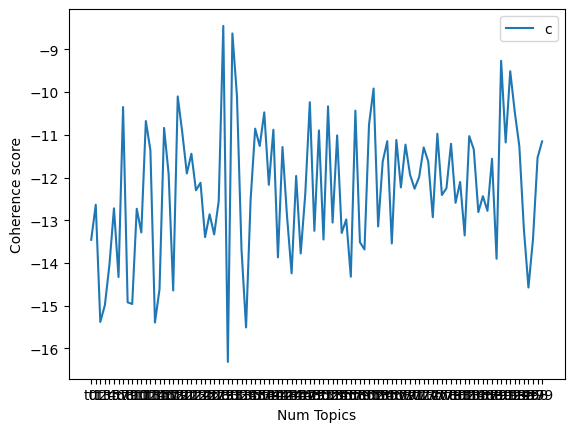

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=df['attributes'], dictionary=id2words_AT, coherence='u_mass')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(0, 100):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname, coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
import numpy as np
np.mean(coherence_ldas)

-12.289722485177823

In [ ]:
lda_10 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus_AT,
    id2word=id2words_AT,
    num_topics=10,
    random_state=42,
    chunksize=1000,
    passes=10)


Coherence Score:  [-3.838217076228711, -3.0755687440491455, -4.602174787486589, -3.7784126715431223, -4.185670809346289, -3.0890808283178917, -3.363482595086109, -3.6017590589103485, -3.005101988584628, -3.5147287842696247]


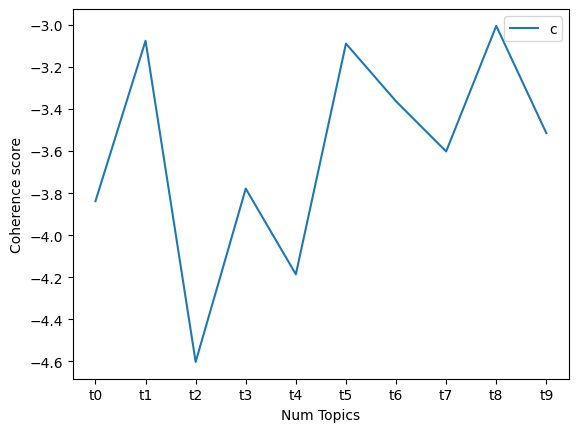

-3.605419734382246

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_10, texts=df['attributes'], dictionary=id2words_AT, coherence='u_mass')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(0, 10):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname, coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
import numpy as np
np.mean(coherence_ldas)

In [ ]:
lda_50 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus_AT,
    id2word=id2words_AT,
    num_topics=50,
    random_state=42,
    chunksize=1000,
    passes=10)


Coherence Score:  [-5.214998701394194, -9.13333234007166, -5.3744498091009225, -7.825761836664704, -6.251854032225696, -6.367154713884208, -3.145510404277259, -4.02985392796189, -3.6079824968700844, -8.45681771010282, -9.237910457427827, -5.068660631187219, -10.852636654480078, -7.155235421458312, -6.892447776586146, -9.246501368536004, -6.943168593298044, -7.365837194903185, -9.09957293095766, -5.275140053999115, -5.903638154760006, -5.267318027730344, -8.955609014902597, -7.040778418159293, -3.4320030661508016, -9.514113377607863, -8.77603280913206, -5.443188190367331, -9.085704243420025, -5.242964729331482, -4.952585208646636, -7.401992028205557, -7.030132616259415, -6.225339851380686, -7.014837392751317, -7.890175023354007, -7.302554926413656, -5.621145606812381, -3.434147393522051, -4.256010177879862, -8.544065009289815, -3.319854868520327, -6.786221822001381, -9.169996852960857, -5.895550767977558, -9.35880782860667, -9.110566800472741, -5.657899111530283, -7.238168430117165, -8

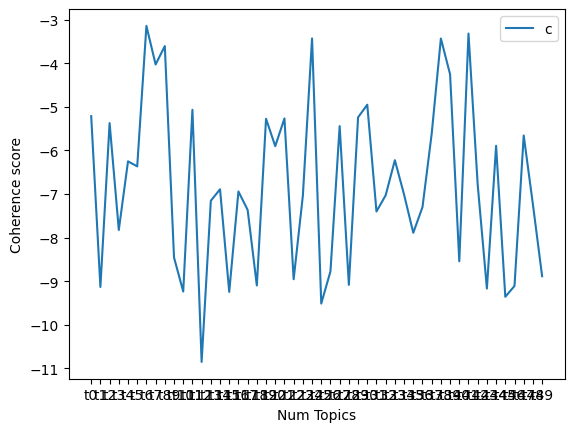

-6.806048448676474

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_50, texts=df['attributes'], dictionary=id2words_AT, coherence='u_mass')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(0, 50):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname, coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
import numpy as np
np.mean(coherence_ldas)

In [ ]:
lda_150 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus_AT,
    id2word=id2words_AT,
    num_topics=150,
    random_state=42,
    chunksize=1000,
    passes=10)


Coherence Score:  [-8.193940729449674, -12.255316839642328, -7.249681989769876, -14.594547521964003, -6.896850918418746, -11.089611048314854, -8.40842664124526, -7.8457097174256365, -9.908460057490183, -10.414222028025753, -6.669593270246203, -8.383998033879609, -9.125162842786063, -13.37034180829038, -14.393165825678105, -6.613508979862833, -9.21772645060103, -5.746967205287113, -7.27280601740992, -8.581453685887153, -10.847270827163706, -6.693340222847857, -5.741931674920718, -10.717274737499608, -4.906899590899966, -8.011606480848942, -7.75205421866332, -14.847685128550884, -11.877561307849852, -8.355748928835101, -7.758781379788629, -7.489771277704076, -14.97880222029987, -12.094456847997401, -12.785855866414582, -8.793159088905965, -12.73111904220287, -10.689047054047448, -6.829507404045427, -6.090038003930132, -13.167951747641162, -15.576663333090092, -6.112613649265866, -16.042188715889043, -11.406786744744158, -6.890430555585025, -8.656957599948063, -4.261705488715109, -13.292

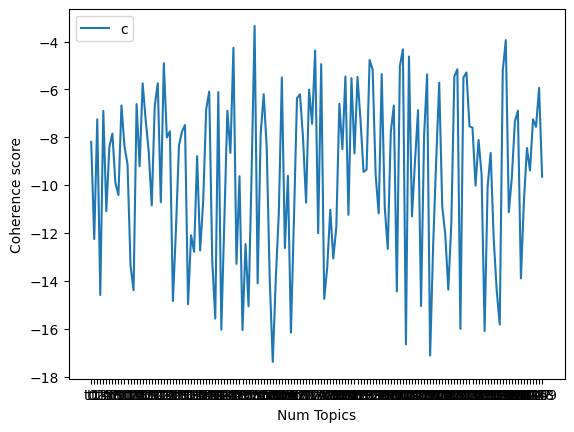

-9.575305269898923

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_150, texts=df['attributes'], dictionary=id2words_AT, coherence='u_mass')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(0, 150):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname, coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
import numpy as np
np.mean(coherence_ldas)

Given that, in general, a lower average u-mass score is better, we choose to stick with the 100 topics.

In [68]:
lda_AT = gensim.models.ldamulticore.LdaMulticore.load('output/model_AT/model_AT.model')
lda_AT[id2words_AT.doc2bow(df['attributes'][0])]

[(1, 0.03416817),
 (6, 0.03505927),
 (7, 0.034502186),
 (21, 0.095019),
 (25, 0.07791794),
 (26, 0.038141724),
 (34, 0.044165302),
 (37, 0.087743565),
 (39, 0.0464115),
 (40, 0.035103563),
 (51, 0.06869637),
 (66, 0.24530037),
 (67, 0.031802364),
 (78, 0.03208574),
 (90, 0.032335844),
 (99, 0.03526737)]

In [69]:
df_topics = df.copy()

In [70]:
df_topics['topic_AT'] = df_topics['attributes'].apply(lambda x: lda_AT[id2words_AT.doc2bow(x)])

In [71]:
df_topics

,title,character,attributes,agents,patient,file_name,topic_AT
0,A Very Special Love,Laida Magtalas,"[little, job, strike, minute, last, friendly, ...","[make, start, remain, revel, say, see, apply, ...","[make, humiliate, find, call, see, wish, send,...",U-W_33267.json,"[(1, 0.03416705), (6, 0.035074674), (7, 0.0345..."
1,A Very Special Love,Miggy,"[little, true, creative, last, first, friendly...","[garner, pat, learn, embarrass, put, wake, try...","[prompt, prove, see, present, embarrass, defend]",U-W_33267.json,"[(2, 0.042232096), (7, 0.04781313), (15, 0.097..."
2,Man of the Frontier,Hartley Moore,[scheme],[],[],M_19001.json,"[(70, 0.5049977)]"
4,Man of the Frontier,Gene Autry,"[first, crime, friend, dangerous]","[ride, arrive, apprehend, go]","[accuse, kill, hire]",M_19001.json,"[(0, 0.37996218), (61, 0.42403135)]"
5,Man of the Frontier,Steve Conway,"[jealous, desperate]","[steal, rob, join]",[],M_19001.json,"[(24, 0.3366664), (26, 0.3366659)]"
...,...,...,...,...,...,...,...
261851,Jerusalem Countdown (film),Jackson,"[inevitable, agent, disastrous, alleged, resul...","[refuse, tell, try, inform]",[warn],J-K_14214.json,"[(12, 0.08651931), (17, 0.095563255), (35, 0.0..."
261852,Jerusalem Countdown (film),Stacy Keach,"[inevitable, disastrous]",[],[],J-K_14214.json,"[(17, 0.3366631), (85, 0.33666152)]"
261854,Jerusalem Countdown (film),Matthew Dean,"[phone, agent, fail, vehicle, contact, terrori...","[work, berate, infiltrate]","[find, spot, destroy, kill, take, berate]",J-K_14214.json,"[(1, 0.08416876), (9, 0.08416971), (27, 0.0841..."
261855,Jerusalem Countdown (film),Nick Jameson,"[superior, former, fail]",[],[],J-K_14214.json,"[(9, 0.2525083), (27, 0.25249708), (48, 0.2524..."


Iniziato a 10:50
Finito a 10:54

## Visualize

In [64]:
pyLDAvis.enable_notebook()

In [65]:
vis = pyLDAvis.gensim.prepare(lda_AT, corpus_AT, id2words_AT, mds="mmds", R=30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [66]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
47    -0.328574  0.029125       1        1  2.300905
7      0.128216 -0.225887       2        1  2.067512
43     0.025025 -0.027755       3        1  2.020132
21    -0.361371 -0.191517       4        1  1.809181
12     0.212830 -0.159683       5        1  1.576654
...         ...       ...     ...      ...       ...
80     0.138565 -0.347068      96        1  0.530670
40     0.138357 -0.407020      97        1  0.522830
5      0.334908  0.352282      98        1  0.517588
68    -0.094736 -0.514164      99        1  0.512664
8     -0.194915  0.149669     100        1  0.471667

[100 rows x 5 columns], topic_info=        Term          Freq         Total  Category  logprob  loglift
107   former  10551.000000  10551.000000   Default  30.0000  30.0000
178     good  10784.000000  10784.000000   Default  29.0000  29.0000
282     high   5412.000000   5412.000000   Default  28.0000  28.0000
513  brother   5487.000000   5487.000000   Default  27.0000  27.0000
160     year   5692.000000   5692.000000   Default  26.0000  26.0000
..       ...           ...           ...       ...      ...      ...
340    house     69.569693   3291.018915  Topic100  -4.5538   1.5000
55    father     67.912034   7523.082882  Topic100  -4.5779   0.6491
286    child     63.663608   3335.521561  Topic100  -4.6425   1.3979
48     young     62.845602  23230.956867  Topic100  -4.6555  -0.5559
255   mother     56.514468   5699.543338  Topic100  -4.7617   0.7430

[4026 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
469      21  0.999112    abandon
1454     93  0.997328    ability
177       1  0.022693       able
177       2  0.009326       able
177       3  0.084555       able
...     ...       ...        ...
6606     95  0.980540  youngster
1060     57  0.995137      youth
3171     78  0.993518   youthful
7401     12  0.982683   zamindar
3514     77  0.990870     zombie

[10170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[48, 8, 44, 22, 13, 28, 3, 16, 55, 49, 64, 7, 53, 38, 24, 100, 4, 66, 19, 58, 75, 10, 23, 78, 83, 27, 72, 40, 36, 62, 68, 59, 65, 91, 97, 95, 26, 45, 80, 47, 67, 60, 37, 98, 14, 1, 90, 42, 85, 89, 11, 39, 32, 46, 86, 74, 50, 35, 54, 29, 84, 70, 33, 31, 15, 61, 96, 63, 52, 82, 93, 5, 88, 43, 30, 34, 57, 21, 87, 2, 20, 92, 79, 94, 73, 76, 99, 77, 71, 17, 25, 12, 18, 51, 56, 81, 41, 6, 69, 9])

In [72]:
pyLDAvis.save_html(vis, 'output/model_AT/vis_lda_attributes.html')

# Agent

In [73]:
id2words_AV = corpora.Dictionary(df['agents'])

corpus_AV = []
for text in df['agents']:
    new = id2words_AV.doc2bow(text)
    corpus_AV.append(new)

In [74]:
word = id2words_AV[10]
word

'see'

In [79]:
lda_AV = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus_AV,
    id2word=id2words_AV,
    num_topics=100,
    random_state=42,
    chunksize=1000,
    passes=10)

In [80]:
lda_AV.save('output/model_AV/model_AV.model')

In [81]:
lda_AV = gensim.models.ldamulticore.LdaMulticore.load('output/model_AV/model_AV.model')
lda_AV[id2words_AV.doc2bow(df['agents'][0])]

[(4, 0.076991916),
 (13, 0.079599716),
 (16, 0.07781264),
 (22, 0.15877663),
 (24, 0.07688681),
 (31, 0.08238296),
 (76, 0.07997739),
 (83, 0.07215277),
 (90, 0.07672368),
 (92, 0.077057034),
 (93, 0.07805495)]

In [82]:
df_topics['topic_AV'] = df_topics['agents'].apply(lambda x: lda_AV[id2words_AV.doc2bow(x)])

In [83]:
df_topics

,title,character,attributes,agents,patient,file_name,topic_AT,topic_AV
0,A Very Special Love,Laida Magtalas,"[little, job, strike, minute, last, friendly, ...","[make, start, remain, revel, say, see, apply, ...","[make, humiliate, find, call, see, wish, send,...",U-W_33267.json,"[(1, 0.03416705), (6, 0.035074674), (7, 0.0345...","[(4, 0.076996274), (13, 0.07959385), (16, 0.07..."
1,A Very Special Love,Miggy,"[little, true, creative, last, first, friendly...","[garner, pat, learn, embarrass, put, wake, try...","[prompt, prove, see, present, embarrass, defend]",U-W_33267.json,"[(2, 0.042232096), (7, 0.04781313), (15, 0.097...","[(2, 0.35447484), (10, 0.114224054), (12, 0.21..."
2,Man of the Frontier,Hartley Moore,[scheme],[],[],M_19001.json,"[(70, 0.5049977)]",[]
4,Man of the Frontier,Gene Autry,"[first, crime, friend, dangerous]","[ride, arrive, apprehend, go]","[accuse, kill, hire]",M_19001.json,"[(0, 0.37996218), (61, 0.42403135)]","[(43, 0.36334428), (94, 0.4406542)]"
5,Man of the Frontier,Steve Conway,"[jealous, desperate]","[steal, rob, join]",[],M_19001.json,"[(24, 0.3366664), (26, 0.3366659)]","[(77, 0.2524947), (95, 0.25250143), (99, 0.252..."
...,...,...,...,...,...,...,...,...
261851,Jerusalem Countdown (film),Jackson,"[inevitable, agent, disastrous, alleged, resul...","[refuse, tell, try, inform]",[warn],J-K_14214.json,"[(12, 0.08651931), (17, 0.095563255), (35, 0.0...","[(95, 0.80199826)]"
261852,Jerusalem Countdown (film),Stacy Keach,"[inevitable, disastrous]",[],[],J-K_14214.json,"[(17, 0.3366631), (85, 0.33666152)]",[]
261854,Jerusalem Countdown (film),Matthew Dean,"[phone, agent, fail, vehicle, contact, terrori...","[work, berate, infiltrate]","[find, spot, destroy, kill, take, berate]",J-K_14214.json,"[(1, 0.08416876), (9, 0.08416971), (27, 0.0841...","[(26, 0.3503187), (62, 0.4046781)]"
261855,Jerusalem Countdown (film),Nick Jameson,"[superior, former, fail]",[],[],J-K_14214.json,"[(9, 0.2525083), (27, 0.25249708), (48, 0.2524...",[]


Iniziato a 11:16
Finito a 11:19

## Visualize

In [84]:
pyLDAvis.enable_notebook()

In [85]:
vis = pyLDAvis.gensim.prepare(lda_AV, corpus_AV, id2words_AV, mds="mmds", R=30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [86]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
48    -0.284317  0.239155       1        1  2.471820
52    -0.081008 -0.195744       2        1  2.203736
61    -0.127815 -0.086185       3        1  2.152571
37     0.166603  0.024590       4        1  1.953255
92    -0.022851  0.448296       5        1  1.801091
...         ...       ...     ...      ...       ...
96    -0.476950 -0.036764      96        1  0.323217
8     -0.235959  0.326193      97        1  0.315914
44    -0.381875  0.297179      98        1  0.302941
55    -0.360072 -0.322681      99        1  0.281852
78    -0.504940 -0.175205     100        1  0.235082

[100 rows x 5 columns], topic_info=      Term         Freq        Total  Category  logprob  loglift
36    meet  8077.000000  8077.000000   Default  30.0000  30.0000
10     see  6320.000000  6320.000000   Default  29.0000  29.0000
99  decide  6173.000000  6173.000000   Default  28.0000  28.0000
83    come  5421.000000  5421.000000   Default  27.0000  27.0000
41  return  5886.000000  5886.000000   Default  26.0000  26.0000
..     ...          ...          ...       ...      ...      ...
29   begin     0.023056  4624.792850  Topic100 -10.9324  -6.1560
4     make     0.022883  5188.069617  Topic100 -10.9399  -6.2785
60    want     0.022869  5563.965484  Topic100 -10.9405  -6.3491
36    meet     0.022866  8077.209027  Topic100 -10.9407  -6.7219
10     see     0.022848  6320.591070  Topic100 -10.9414  -6.4775

[3920 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
519      22  0.998068   abandon
1323     57  0.836156  abdicate
940      56  0.993403    abduct
1375      1  0.944948     abide
504      82  0.974203     abort
...     ...       ...       ...
1720     96  0.988033      wrap
609      63  0.963900   wrestle
1138     75  0.853405   wriggle
182      21  0.999460     write
827      15  0.992770      yell

[3229 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[49, 53, 62, 38, 93, 81, 57, 92, 21, 91, 94, 77, 25, 13, 69, 96, 32, 61, 33, 14, 6, 34, 78, 29, 83, 84, 41, 54, 74, 68, 30, 59, 70, 18, 63, 90, 39, 17, 27, 82, 5, 85, 99, 58, 46, 100, 4, 1, 55, 8, 76, 11, 75, 80, 67, 10, 72, 23, 95, 37, 42, 43, 2, 50, 88, 73, 65, 12, 86, 51, 66, 20, 47, 87, 44, 22, 3, 60, 89, 40, 98, 31, 19, 71, 52, 64, 7, 36, 28, 48, 24, 26, 35, 15, 16, 97, 9, 45, 56, 79])

In [87]:
pyLDAvis.save_html(vis, 'output/model_AV/vis_lda_agents.html')

# Patient

In [84]:
id2words_PV = corpora.Dictionary(df['patient'])

corpus_PV = []
for text in df['patient']:
    new = id2words_PV.doc2bow(text)
    corpus_PV.append(new)

In [85]:
word = id2words_PV[10]
word

'send'

In [90]:
lda_PV = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus_PV,
    id2word=id2words_PV,
    num_topics=100,
    random_state=42,
    chunksize=1000,
    passes=10)

In [91]:
lda_PV.save('output/model_PV/model_PV.model')

Iniziato a 11:26
Finito a 11:28

In [86]:
lda_PV = gensim.models.ldamulticore.LdaMulticore.load('output/model_PV/model_PV.model')
#lda_PV[id2words_PV.doc2bow(df['patient'][0])]

In [97]:
df_topics['topic_PV'] = df_topics['patient'].apply(lambda x: lda_PV[id2words_PV.doc2bow(x)])

In [ ]:
df_topics

## Visualize

In [88]:
pyLDAvis.enable_notebook()

In [89]:
vis = pyLDAvis.gensim.prepare(lda_PV, corpus_PV, id2words_PV, mds="mmds", R=30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [90]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19     0.109514  0.528296       1        1  3.410078
27     0.206170  0.054417       2        1  2.572679
35    -0.201891  0.325809       3        1  2.501812
88    -0.097468  0.578483       4        1  2.138353
53     0.536812 -0.208289       5        1  2.123799
...         ...       ...     ...      ...       ...
49    -0.197629 -0.332690      96        1  0.418364
46    -0.259123  0.331549      97        1  0.408785
69     0.459126  0.012298      98        1  0.388839
47    -0.309657 -0.198348      99        1  0.362472
83    -0.493118 -0.010605     100        1  0.208465

[100 rows x 5 columns], topic_info=       Term          Freq         Total  Category  logprob  loglift
17     kill  10817.000000  10817.000000   Default  30.0000  30.0000
29     meet   5888.000000   5888.000000   Default  29.0000  29.0000
110   shoot   3767.000000   3767.000000   Default  28.0000  28.0000
107   marry   3658.000000   3658.000000   Default  27.0000  27.0000
31     take   9926.000000   9926.000000   Default  26.0000  26.0000
..      ...           ...           ...       ...      ...      ...
25   invite      0.158856   2151.330147  Topic100  -8.4619  -3.3404
26   kidnap      0.158856   1457.992957  Topic100  -8.4619  -2.9514
27     lure      0.158856    565.121348  Topic100  -8.4619  -2.0036
28      man      0.158856    124.343763  Topic100  -8.4619  -0.4897
29     meet      0.158856   5888.596250  Topic100  -8.4619  -4.3474

[4406 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
182      72  0.998799  abandon
245      75  0.996715   abduct
410      65  0.959364    abort
1795     24  0.959341  absolve
1125     75  0.971808   absorb
...     ...       ...      ...
926       6  0.959477     wrap
960      45  0.848777    wreak
207      36  0.996354    write
1734     80  0.948047    wrong
1312     67  0.894933     yank

[1944 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 28, 36, 89, 54, 26, 3, 5, 17, 8, 97, 21, 71, 59, 40, 38, 32, 45, 88, 6, 42, 29, 80, 94, 78, 37, 87, 39, 14, 83, 16, 52, 13, 2, 49, 46, 66, 7, 65, 30, 56, 69, 53, 91, 77, 79, 72, 95, 90, 75, 9, 61, 1, 63, 85, 55, 34, 51, 22, 24, 67, 64, 31, 68, 60, 82, 18, 44, 27, 96, 10, 33, 98, 43, 12, 4, 76, 81, 99, 73, 92, 15, 100, 74, 62, 19, 35, 23, 93, 86, 11, 25, 57, 41, 58, 50, 47, 70, 48, 84])

In [102]:
pyLDAvis.save_html(vis, 'output/model_PV/vis_lda_patient.html')

In [105]:
df_topics.to_csv('output/df_topics.csv', index=False)

# KMeans

In [1]:
import pandas as pd

df_lda = pd.read_csv('output/df_topics.csv')

In [2]:
df_lda.head()

,title,character,attributes,agents,patient,file_name,topic_AT,topic_AV,topic_PV
0,A Very Special Love,Laida Magtalas,"['little', 'job', 'strike', 'minute', 'last', ...","['make', 'start', 'remain', 'revel', 'say', 's...","['make', 'humiliate', 'find', 'call', 'see', '...",U-W_33267.json,"[(1, 0.03416705), (6, 0.035074674), (7, 0.0345...","[(4, 0.076996274), (13, 0.07959385), (16, 0.07...","[(29, 0.18632422), (31, 0.0911057), (38, 0.088..."
1,A Very Special Love,Miggy,"['little', 'true', 'creative', 'last', 'first'...","['garner', 'pat', 'learn', 'embarrass', 'put',...","['prompt', 'prove', 'see', 'present', 'embarra...",U-W_33267.json,"[(2, 0.042232096), (7, 0.04781313), (15, 0.097...","[(2, 0.35447484), (10, 0.114224054), (12, 0.21...","[(9, 0.18428667), (51, 0.24424239), (53, 0.144..."
2,Man of the Frontier,Hartley Moore,['scheme'],[],[],M_19001.json,"[(70, 0.5049977)]",[],[]
3,Man of the Frontier,Gene Autry,"['first', 'crime', 'friend', 'dangerous']","['ride', 'arrive', 'apprehend', 'go']","['accuse', 'kill', 'hire']",M_19001.json,"[(0, 0.37996218), (61, 0.42403135)]","[(43, 0.36334428), (94, 0.4406542)]","[(12, 0.25249994), (19, 0.25250024), (96, 0.25..."
4,Man of the Frontier,Steve Conway,"['jealous', 'desperate']","['steal', 'rob', 'join']",[],M_19001.json,"[(24, 0.3366664), (26, 0.3366659)]","[(77, 0.2524947), (95, 0.25250143), (99, 0.252...",[]


In [3]:
df_lda['topic_AT'] = df_lda['topic_AT'].apply(eval)
df_lda['topic_AV'] = df_lda['topic_AV'].apply(eval)
df_lda['topic_PV'] = df_lda['topic_PV'].apply(eval)

In [8]:
df_lda['topic_PV'][0]

[(29, 0.18632422),
 (31, 0.0911057),
 (38, 0.088554084),
 (51, 0.18789373),
 (54, 0.079233095),
 (64, 0.07769127),
 (96, 0.13074692),
 (98, 0.087681085)]

In [6]:
from tqdm import tqdm


def extract_topic_values(topic_list):
    topic_values = [0] * 100  
    for topic_id, value in topic_list:
        topic_values[topic_id] = value
    return topic_values


for topic_type in ['AT', 'AV', 'PV']:
    tqdm.pandas(desc=f'Processing {topic_type} topics')
    col_name_prefix = f'{topic_type}_'
    topic_col = f'topic_{topic_type}'
    new_columns = df_lda[topic_col].progress_apply(extract_topic_values)
    for i in range(100):
        col_name = col_name_prefix + str(i)
        df_lda[col_name] = [values[i] for values in new_columns]

Processing AT topics: 100%|██████████| 194215/194215 [00:00<00:00, 215738.53it/s]
/var/folders/5c/228d25ts5q930z1l80pxc9qh0000gn/T/ipykernel_45160/687140306.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lda[col_name] = [values[i] for values in new_columns]
/var/folders/5c/228d25ts5q930z1l80pxc9qh0000gn/T/ipykernel_45160/687140306.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lda[col_name] = [values[i] for values in new_columns]
/var/folders/5c/228d25ts5q930z1l80pxc9qh0000gn/T/ipykernel_45160/687140306.py:18: 

In [7]:
df_lda.head()

,title,character,attributes,agents,patient,file_name,topic_AT,topic_AV,topic_PV,AT_0,...,PV_90,PV_91,PV_92,PV_93,PV_94,PV_95,PV_96,PV_97,PV_98,PV_99
0,A Very Special Love,Laida Magtalas,"['little', 'job', 'strike', 'minute', 'last', ...","['make', 'start', 'remain', 'revel', 'say', 's...","['make', 'humiliate', 'find', 'call', 'see', '...",U-W_33267.json,"[(1, 0.03416705), (6, 0.035074674), (7, 0.0345...","[(4, 0.076996274), (13, 0.07959385), (16, 0.07...","[(29, 0.18632422), (31, 0.0911057), (38, 0.088...",0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.130747,0.0,0.087681,0.0
1,A Very Special Love,Miggy,"['little', 'true', 'creative', 'last', 'first'...","['garner', 'pat', 'learn', 'embarrass', 'put',...","['prompt', 'prove', 'see', 'present', 'embarra...",U-W_33267.json,"[(2, 0.042232096), (7, 0.04781313), (15, 0.097...","[(2, 0.35447484), (10, 0.114224054), (12, 0.21...","[(9, 0.18428667), (51, 0.24424239), (53, 0.144...",0.000000,...,0.0,0.147185,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,Man of the Frontier,Hartley Moore,['scheme'],[],[],M_19001.json,"[(70, 0.5049977)]",[],[],0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3,Man of the Frontier,Gene Autry,"['first', 'crime', 'friend', 'dangerous']","['ride', 'arrive', 'apprehend', 'go']","['accuse', 'kill', 'hire']",M_19001.json,"[(0, 0.37996218), (61, 0.42403135)]","[(43, 0.36334428), (94, 0.4406542)]","[(12, 0.25249994), (19, 0.25250024), (96, 0.25...",0.379962,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.252499,0.0,0.000000,0.0
4,Man of the Frontier,Steve Conway,"['jealous', 'desperate']","['steal', 'rob', 'join']",[],M_19001.json,"[(24, 0.3366664), (26, 0.3366659)]","[(77, 0.2524947), (95, 0.25250143), (99, 0.252...",[],0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [10]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [11]:
feature_columns = [f'AT_{i}' for i in range(100)] + \
                  [f'AV_{i}' for i in range(100)] + \
                  [f'PV_{i}' for i in range(100)]

In [13]:
df_features = df_lda[feature_columns]

In [16]:

n_clusters = 100


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_lda['cluster_label'] = kmeans.fit_predict(df_features)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
df_lda.query("cluster_label == 27")

,title,character,attributes,agents,patient,file_name,topic_AT,topic_AV,topic_PV,AT_0,...,PV_91,PV_92,PV_93,PV_94,PV_95,PV_96,PV_97,PV_98,PV_99,cluster_label
2,Man of the Frontier,Hartley Moore,['scheme'],[],[],M_19001.json,"[(70, 0.5049977)]",[],[],0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27
7,On Her Majesty's Secret Service (film),James Bond,"['mission', 'troubled', 'hypnotic', 'various',...","['track', 'break', 'pursue', 'head', 'meet', '...","['forbid', 'thank', 'catch', 'bury', 'meet', '...",N-O_23027.json,"[(0, 0.048731692), (2, 0.034728035), (7, 0.050...","[(13, 0.061820794), (19, 0.05262134), (28, 0.0...","[(6, 0.06699221), (7, 0.059237365), (10, 0.132...",0.048732,...,0.0,0.0,0.0,0.066413,0.0,0.0,0.0,0.0,0.0,27
11,On Her Majesty's Secret Service (film),Hilary Bray,['genealogist'],['pose'],[],N-O_23027.json,[],"[(54, 0.50499874)]",[],0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27
21,D.E.B.S. (2004 film),Max,"['fellow', 'art', 'russian', 'pushy', 'promise...","['speak', 'remind', 'observe', 'respond', 'ass...","['remind', 'task', 'attend', 'allow', 'replace...",D_06112.json,"[(12, 0.11856919), (13, 0.055718116), (21, 0.2...","[(0, 0.08392461), (1, 0.078714386), (6, 0.0895...","[(2, 0.33444527), (8, 0.13917258), (62, 0.1818...",0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27
23,D.E.B.S. (2004 film),Amy,"['answer', 'agent', 'advice', 'image', 'fellow...","['remind', 'catch', 'become', 'meet', 'try', '...","['coerce', 'join', 'see', 'attend', 'demand', ...",D_06112.json,"[(1, 0.022306394), (12, 0.07212155), (13, 0.02...","[(20, 0.23530325), (49, 0.38301116), (52, 0.17...","[(4, 0.05282084), (6, 0.05348486), (13, 0.0500...",0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194183,We're in the Money (film),ditsy,['ditsy'],[],[],U-W_36334.json,[],[],[],0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27
194185,We're in the Money (film),Hugh Herbert,['ditsy'],[],[],U-W_36334.json,[],[],[],0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27
194186,We're in the Money (film),Claire LeClaire,['wealthy'],['nestle'],['marry'],U-W_36334.json,[],[],"[(41, 0.5049999)]",0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27
194188,We're in the Money (film),Ross Alexander,['wealthy'],[],[],U-W_36334.json,[],[],[],0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27


/var/folders/5c/228d25ts5q930z1l80pxc9qh0000gn/T/ipykernel_45160/1335729207.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_lda, x='cluster_label', bins=n_clusters, palette=pastel_palette)


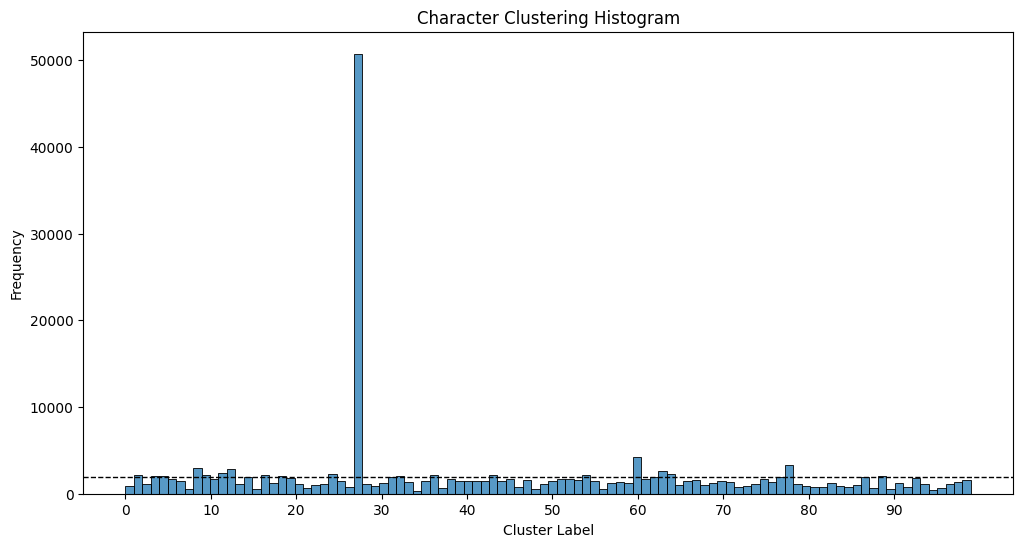

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




pastel_palette = sns.color_palette("pastel", n_colors=n_clusters)


plt.figure(figsize=(12, 6))
sns.histplot(data=df_lda, x='cluster_label', bins=n_clusters, palette=pastel_palette)
plt.axhline(y=df_lda.groupby('cluster_label')['character'].count().mean(), color='black', linestyle='--', linewidth=1, label='Mean')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.title('Character Clustering Histogram')
plt.xticks(range(0, 99, 10)) 
plt.show()


In [47]:
print("class:", df_lda['cluster_label'].value_counts().idxmax())
print("number of characters:", df_lda['cluster_label'].value_counts().max())

class: 27
number of characters: 50757


In [48]:
print("class:", df_lda['cluster_label'].value_counts().idxmin())
print("number of characters:", df_lda['cluster_label'].value_counts().min())

class: 34
number of characters: 307


In [50]:
df_lda.groupby('cluster_label')['character'].count().mean()

1942.15

In [51]:
df_lda.query('cluster_label != 27').groupby('cluster_label')['character'].count().mean()

1449.0707070707072

In [62]:
df_lda.query("cluster_label == 34").head(50)

,title,character,attributes,agents,patient,file_name,topic_AT,topic_AV,topic_PV,AT_0,...,PV_91,PV_92,PV_93,PV_94,PV_95,PV_96,PV_97,PV_98,PV_99,cluster_label
433,Kevin & Perry Go Large,Sharon,"['marriage', 'popular', 'famous', 'virgin', 't...","['boast', 'reappear', 'confront']",[],J-K_15611.json,"[(25, 0.1286008), (43, 0.22373554), (52, 0.081...","[(0, 0.25250244), (59, 0.25249574), (86, 0.252...",[],0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
526,The Return of Count Yorga,Jennifer,"['next', 'family', 'death', 'maid', 'vengeful'...","['slap', 'find']",['kill'],Q-R_27972.json,"[(10, 0.091105), (25, 0.12495546), (31, 0.0824...","[(59, 0.6699929)]","[(19, 0.50499994)]",0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
1154,Desperate Journey,Kaethe Brahms,"['doctor', 'group', 'parent']","['reject', 'die', 'advise', 'take', 'arrive']","['capture', 'take']",D_06684.json,"[(15, 0.33017957), (85, 0.4248034)]","[(9, 0.18984063), (59, 0.4093396), (82, 0.2391...","[(35, 0.3285955), (44, 0.3447376)]",0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
2226,Burnt (film),Kaitlin,"['house', 'sous', 'host', 'front']",['advise'],[],B_03563.json,"[(21, 0.3166447), (23, 0.22296037), (98, 0.266...","[(59, 0.5049997)]",[],0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
2473,Here Comes the Boom,Ken Dietrich,"['original', 'stuck', 'man', 'opponent', 'dang...","['deserve', 'cancel']",['anger'],H_11631.json,"[(20, 0.31225654), (43, 0.1783267), (61, 0.177...","[(59, 0.33666837), (84, 0.3366604)]","[(69, 0.5049998)]",0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
2898,Semana santa,Antonio Alvarez,"['exist', 'old', 'teenage', 'powerful', 'crimi...","['advise', 'murder', 'keep', 'get']",['expel'],S_28818.json,"[(2, 0.10058863), (16, 0.090564884), (28, 0.09...","[(4, 0.23133618), (7, 0.28604516), (59, 0.2886...","[(81, 0.5049992)]",0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
3325,Til Death (film),Walter Currie,"['former', 'money', 'fellow', 'cop', 'detectiv...","['arrive', 'compensate', 'confront', 'rearm']","['barricade', 'shoot', 'give', 'leave', 'compe...",T_32419.json,"[(3, 0.088330194), (5, 0.08433452), (19, 0.088...","[(0, 0.36681786), (59, 0.3881749)]","[(54, 0.24323137), (55, 0.41128442), (77, 0.18...",0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
3795,Drunks (film),Shelly,"['basement', 'driving', 'addict', 'marriage', ...","['lose', 'idolize']","['lose', 'idolize', 'replace']",D_07484.json,"[(12, 0.043540247), (17, 0.2577853), (20, 0.04...","[(59, 0.33666205), (80, 0.33666864)]","[(2, 0.25249854), (22, 0.2524985), (79, 0.2525...",0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
3797,Drunks (film),Debbie,"['basement', 'driving', 'marriage', 'alcoholis...","['lose', 'idolize']","['lose', 'idolize', 'replace']",D_07484.json,"[(12, 0.059282064), (17, 0.1535672), (20, 0.06...","[(59, 0.33666208), (80, 0.33666864)]","[(2, 0.25249854), (22, 0.2524985), (79, 0.2525...",0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34
4070,Ulkuthu,Shanmugam,"['good', 'sister', 'pipe']","['work', 'die', 'slap']",[],U-W_34275.json,"[(7, 0.25297758), (43, 0.25178632), (55, 0.252...","[(59, 0.4289174), (82, 0.32608107)]",[],0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,34


In [67]:
df_lda.query("title == 'Harry Potter and the Prisoner of Azkaban (film)'")

,title,character,attributes,agents,patient,file_name,topic_AT,topic_AV,topic_PV,AT_0,...,PV_91,PV_92,PV_93,PV_94,PV_95,PV_96,PV_97,PV_98,PV_99,cluster_label
154691,Harry Potter and the Prisoner of Azkaban (film),Harry Potter,"['convict', 'innocence', 'determined', 'black'...","['sneak', 'fly', 'faint', 'flee', 'take', 'res...","['insult', 'catch', 'punish', 'assure', 'save'...",H_11326.json,"[(0, 0.06820464), (15, 0.07181094), (17, 0.063...","[(1, 0.104772225), (39, 0.097384945), (41, 0.1...","[(7, 0.11222231), (23, 0.22580206), (25, 0.114...",0.068205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27
154692,Harry Potter and the Prisoner of Azkaban (film),Vernon,['visit'],[],[],H_11326.json,"[(31, 0.5049988)]",[],[],0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27
154693,Harry Potter and the Prisoner of Azkaban (film),Marge,['visit'],[],[],H_11326.json,"[(31, 0.5049988)]",[],[],0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27
154694,Harry Potter and the Prisoner of Azkaban (film),Ron Weasley,"['convict', 'black', 'good', 'large', 'pet']",['learn'],['bite'],H_11326.json,"[(3, 0.16855331), (15, 0.33550283), (35, 0.168...","[(12, 0.5049999)]","[(24, 0.50499976)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87
154695,Harry Potter and the Prisoner of Azkaban (film),Hermione Granger,['several'],[],['give'],H_11326.json,[],[],"[(28, 0.5049997)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27
154696,Harry Potter and the Prisoner of Azkaban (film),Voldemort,[],[],['kill'],H_11326.json,[],[],"[(19, 0.50499994)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78
154697,Harry Potter and the Prisoner of Azkaban (film),Remus Lupin,"['form', 'animal', 'supporter', 'convict']",[],[],H_11326.json,"[(15, 0.20200379), (31, 0.20200284), (42, 0.20...",[],[],0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27
154698,Harry Potter and the Prisoner of Azkaban (film),Dumbledore,['convict'],['announce'],['warn'],H_11326.json,"[(15, 0.504997)]","[(75, 0.50499946)]","[(16, 0.50499964)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87
154699,Harry Potter and the Prisoner of Azkaban (film),Rubeus Hagrid,"['awry', 'first']",[],['appoint'],H_11326.json,"[(62, 0.6699932)]",[],"[(67, 0.5049995)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27
154700,Harry Potter and the Prisoner of Azkaban (film),Draco Malfoy,[],['provoke'],['attack'],H_11326.json,[],"[(72, 0.50499624)]","[(7, 0.5049998)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66


In [71]:
df_lda.query("character == 'Voldemort'").head(50)

,title,character,attributes,agents,patient,file_name,topic_AT,topic_AV,topic_PV,AT_0,...,PV_91,PV_92,PV_93,PV_94,PV_95,PV_96,PV_97,PV_98,PV_99,cluster_label
2922,Harry Potter and the Order of the Phoenix (film),Voldemort,[],"['seek', 'possess', 'return', 'torture', 'kill...",['drive'],H_11324.json,[],"[(37, 0.12625039), (60, 0.12625062), (64, 0.12...","[(88, 0.5049995)]",0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,54
45906,Harry Potter and the Philosopher's Stone (film),Voldemort,"['head', 'stone', 'back', 'teacher', 'weakened']",['want'],"['reveal', 'want']",H_11325.json,"[(25, 0.16852717), (32, 0.33662325), (60, 0.16...","[(62, 0.5049995)]","[(55, 0.33666635), (89, 0.3366667)]",0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,98
63806,Harry Potter and the Goblet of Fire (film),Voldemort,"['first', 'current', 'previous', 'long', 'man'...","['recognise', 'summon']","['recognise', 'resurrect', 'summon']",H_11322.json,"[(25, 0.4526783), (32, 0.15565555), (33, 0.253...","[(70, 0.33666712), (84, 0.3366641)]","[(6, 0.25249654), (27, 0.25249788), (56, 0.252...",0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,11
81833,Harry Potter and the Half-Blood Prince (film),Voldemort,"['secret', 'magical', 'muggle', 'young']","['choose', 'seek', 'tighten']",['surmise'],H_11323.json,"[(77, 0.26724604), (97, 0.4877526)]","[(64, 0.33666706), (90, 0.33666536)]",[],0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,94
118237,Harry Potter and the Deathly Hallows – Part 1,Voldemort,"['elderly', 'powerful', 'mad']","['retrieve', 'confiscate']",['tell'],H_11320.json,"[(24, 0.25249907), (37, 0.25249913), (78, 0.25...","[(48, 0.3366714), (60, 0.33665168)]",[],0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,63
123557,Harry Potter and the Deathly Hallows – Part 2,Voldemort,"['accidental', 'dark', 'many', 'apparent']","['command', 'perform', 'display', 'kill', 'cas...","['destroy', 'serve', 'abandon', 'confront']",H_11321.json,"[(2, 0.20201387), (15, 0.20200056), (26, 0.401...","[(39, 0.31816968), (51, 0.18266074), (56, 0.20...","[(32, 0.20200072), (81, 0.36972624), (95, 0.23...",0.0,...,0.0,0.0,0.0,0.0,0.234272,0.0,0.0,0.0,0.0,17
154696,Harry Potter and the Prisoner of Azkaban (film),Voldemort,[],[],['kill'],H_11326.json,[],[],"[(19, 0.50499994)]",0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,78


In [69]:
df_lda.query("cluster_label == 78").head(50)

,title,character,attributes,agents,patient,file_name,topic_AT,topic_AV,topic_PV,AT_0,...,PV_91,PV_92,PV_93,PV_94,PV_95,PV_96,PV_97,PV_98,PV_99,cluster_label
3,Man of the Frontier,Gene Autry,"['first', 'crime', 'friend', 'dangerous']","['ride', 'arrive', 'apprehend', 'go']","['accuse', 'kill', 'hire']",M_19001.json,"[(0, 0.37996218), (61, 0.42403135)]","[(43, 0.36334428), (94, 0.4406542)]","[(12, 0.25249994), (19, 0.25250024), (96, 0.25...",0.379962,...,0.0,0.0,0.0,0.0,0.0,0.252499,0.0,0.0,0.0000,78
60,The Initiation (film),Andy,['multilevel'],['break'],['kill'],I_13536.json,"[(62, 0.50465167)]","[(32, 0.50499856)]","[(19, 0.50499994)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
152,Sharknado 2: The Second One,Brian,[],[],['kill'],S_29024.json,[],[],"[(19, 0.50499994)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
155,Sharknado 2: The Second One,Chrissie,[],[],['kill'],S_29024.json,[],[],"[(19, 0.50499994)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
172,The Fog (2005 film),Connie,[],[],['kill'],F_09845.json,[],[],"[(19, 0.50499994)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
337,Timecop 2: The Berlin Decision,Adolf Hitler,[],[],['kill'],T_32458.json,[],[],"[(19, 0.50499994)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
510,The Conjuring 2,Ed,"['old', 'haunted', 'fearful', 'ready', 'fright...","['add', 'manage']","['impale', 'warn']",C_05918.json,"[(4, 0.12130715), (22, 0.12209737), (57, 0.226...","[(4, 0.33666834), (71, 0.336663)]","[(16, 0.33667025), (19, 0.33665887)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
606,Doppelgänger (1969 film),Hassler,"['agent', 'double']",[],['kill'],D_07216.json,"[(77, 0.3366665), (89, 0.33666554)]",[],"[(19, 0.50499994)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
691,Revenge of the Nerds II: Nerds in Paradise,Lewis,"['sunny', 'due', 'regional', 'good', 'local', ...","['act', 'believe']","['implore', 'give', 'sleep', 'inform']",Q-R_27071.json,"[(19, 0.1904542), (31, 0.19656146), (43, 0.217...","[(84, 0.33666703), (99, 0.3366656)]","[(19, 0.25248522), (28, 0.25250462), (39, 0.25...",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
692,Revenge of the Nerds II: Nerds in Paradise,Gilbert,[],"['implore', 'give', 'come']",['implore'],Q-R_27071.json,[],"[(18, 0.25249797), (48, 0.2525004), (68, 0.252...","[(19, 0.5049913)]",0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,78
